# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}"))
            
os.environ["S3_ACCESS_KEY"] = "eicS3read"
os.environ["S3_SECRET_KEY"] = "eicS3read"

Welcome to JupyROOT 6.24/06


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.2


# Initialization

In [4]:
%%cpp -d


#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [5]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");


sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [6]:
%%cpp

TFile *qa_file_new =  TFile::Open("s3://dtn01.sdcc.bnl.gov:9000/eictest/ECCE/MC/prop.7/prop.7.1/AI/particleGun/singleElectron/DST_General_particleGun_singleElectron_FEMC.root");
// TFile *qa_file_new = new TFile("singleElectron.lst_FEMC.2k.root");


    
if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

TTree * T = nullptr; 

qa_file_new->GetObject("T", T);

    
if (T == nullptr) 
{
    cout <<"Error, can not open T Tree"<<endl;
    exit(1);
}

# What is in the TTree

Every entry is for one truth particle 

* `m_truth*`: is the MC truth information
  - `m_truthpid`: is the PID in PDG convension
* `m_tr*`: is the recontructed track information
* `FEMC_proj_*`: is the Kalman filter track projection to the reference radius of FEMC
* `FEMC_Tower_E3x3...7x7`: is using the track projection as seed and build 3x3 to 7x7 tower energy sum 
* `centralTowerBinEta` and `centralTowerBinPhi`: are the tower at the track projection
* `FEMC_Tower_*` is the 1D array for towers in a 7x7 patch next to the track projection. 
  - `dEta/phi` are tower to track distance in eta/phi scale. 
  - `iEta_patch/phi` are tower id in the patch relative to the central tower
  - `E` are energy of that tower
  

In [7]:
%%cpp
T->Show(0);

======> EVENT:0
 m_truthenergy   = 9.09628
 m_truthp        = 9.09628
 m_truthpx       = 1.18397
 m_truthpy       = 0.614602
 m_truthpz       = 8.99793
 m_truthpt       = 1.33399
 m_truthphi      = 0.478812
 m_trutheta      = 2.60742
 m_truthpid      = 11
 m_tr_px         = 1.2535
 m_tr_py         = 0.651896
 m_tr_pz         = 9.51136
 m_tr_p          = 9.61573
 m_tr_pt         = 1.41288
 m_tr_phi        = 0.479568
 m_tr_eta        = 2.60548
 m_charge        = -1
 m_chisq         = 0.740525
 m_ndf           = 1
 m_dca           = 0.0377748
 m_tr_x          = 0.00414271
 m_tr_y          = -0.00779065
 m_tr_z          = 3.83299
 FEMC_proj_x     = 39.3124
 FEMC_proj_y     = 22.7934
 FEMC_proj_z     = 310
 FEMC_proj_path_length = 177.598
 FEMC_proj_px    = 1.20213
 FEMC_proj_py    = 0.720207
 FEMC_proj_pz    = 9.44584
 FEMC_Tower_E3x3 = 6.14208
 FEMC_Tower_E5x5 = 6.91483
 FEMC_Tower_E7x7 = 7.31992
 FEMC_centralTowerBinEta = 118
 FEMC_centralTowerBinPhi = 109
 FEMC_nTowerInPatch = 49
 FEMC_

# Suggestion

General event selection: 

`abs(m_tr_p/m_truthp)<5%`, i.e. the track that can be propery reconstructed and useful for analysis. This kick out the electron with hard bremsstrahlung, which is a quite different problem to deal with. We probably want to run the classification with each eta and momentum bin. The current sample is generated within |eta|<0.5, in which BCAL performance is similar. And the momentum cover from 0-20GeV, and we can probably focus on the 2-4 GeV region where physics impact is max.

Further a cut on `E7x7/m_tr_p > 0.5` select the pion sample that is most interesting for the eID problem, which excluse majority of pions that are simply easy to reject. 

Select the follow features in NN classifier input, which take into account of the azimuthal symmetry: 

* `m_tr_p`
* `m_chisq`
* `m_ndf`
* `m_tr_eta`
* `FEMC_Tower_dEta[49]`
* `FEMC_Tower_dPhi[49]`
* `FEMC_Tower_E[49]`

And then I would expect NN should learn about both e/p and shower shape from these variables 

Last to compare ROC curves with 

* `E5x5/m_tr_p` cut only
* cut on NN classification output

We should see a big improvement over all electron efficiency region.

# Check plot

## E/p

Check 7x7 tower sum next to track projection vs turth or reco momentum

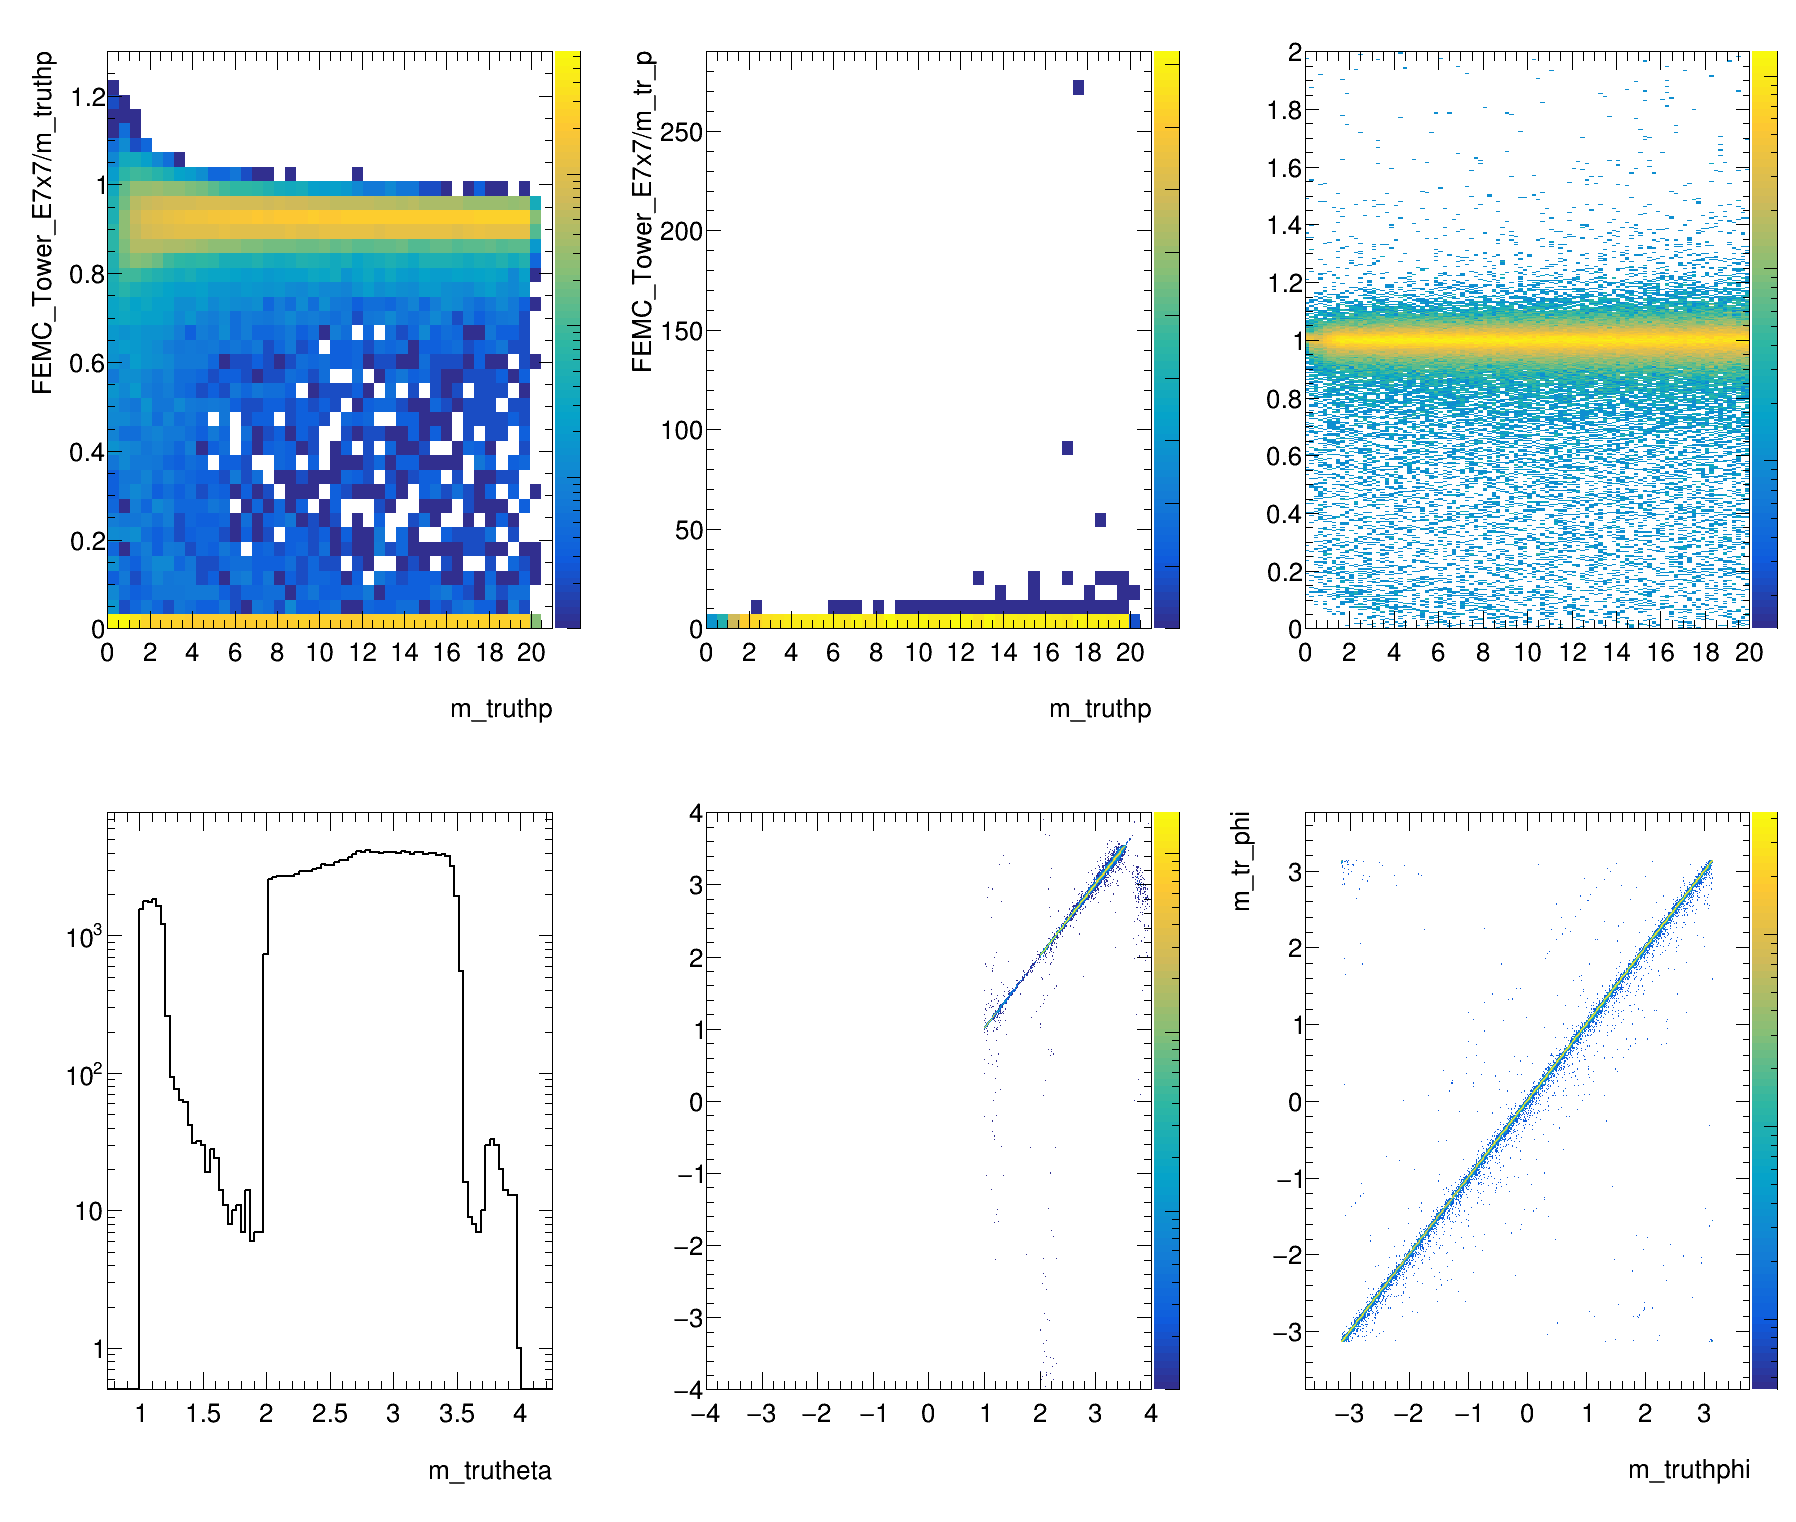

In [8]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(3, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("FEMC_Tower_E7x7/m_truthp:m_truthp","","colz");
        
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("FEMC_Tower_E7x7/m_tr_p:m_truthp","m_tr_p>0","colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_p/m_truthp:m_truthp>>htrackreco(100,0,20,500,0,2)","m_tr_p>0","colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        T->Draw("m_trutheta","m_tr_p>0");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_eta:m_trutheta>>heta(500,-4,4,500,-4,4)","m_tr_p>0", "colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_phi:m_truthphi","m_tr_p>0", "colz");
    }
    
    
    
    c1->Draw();
}

## Track based shower profile check

### Shower shape in 7x7 tower patch grid

Check 7x7 tower patch next to the track projection with weight of the tower energy


Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


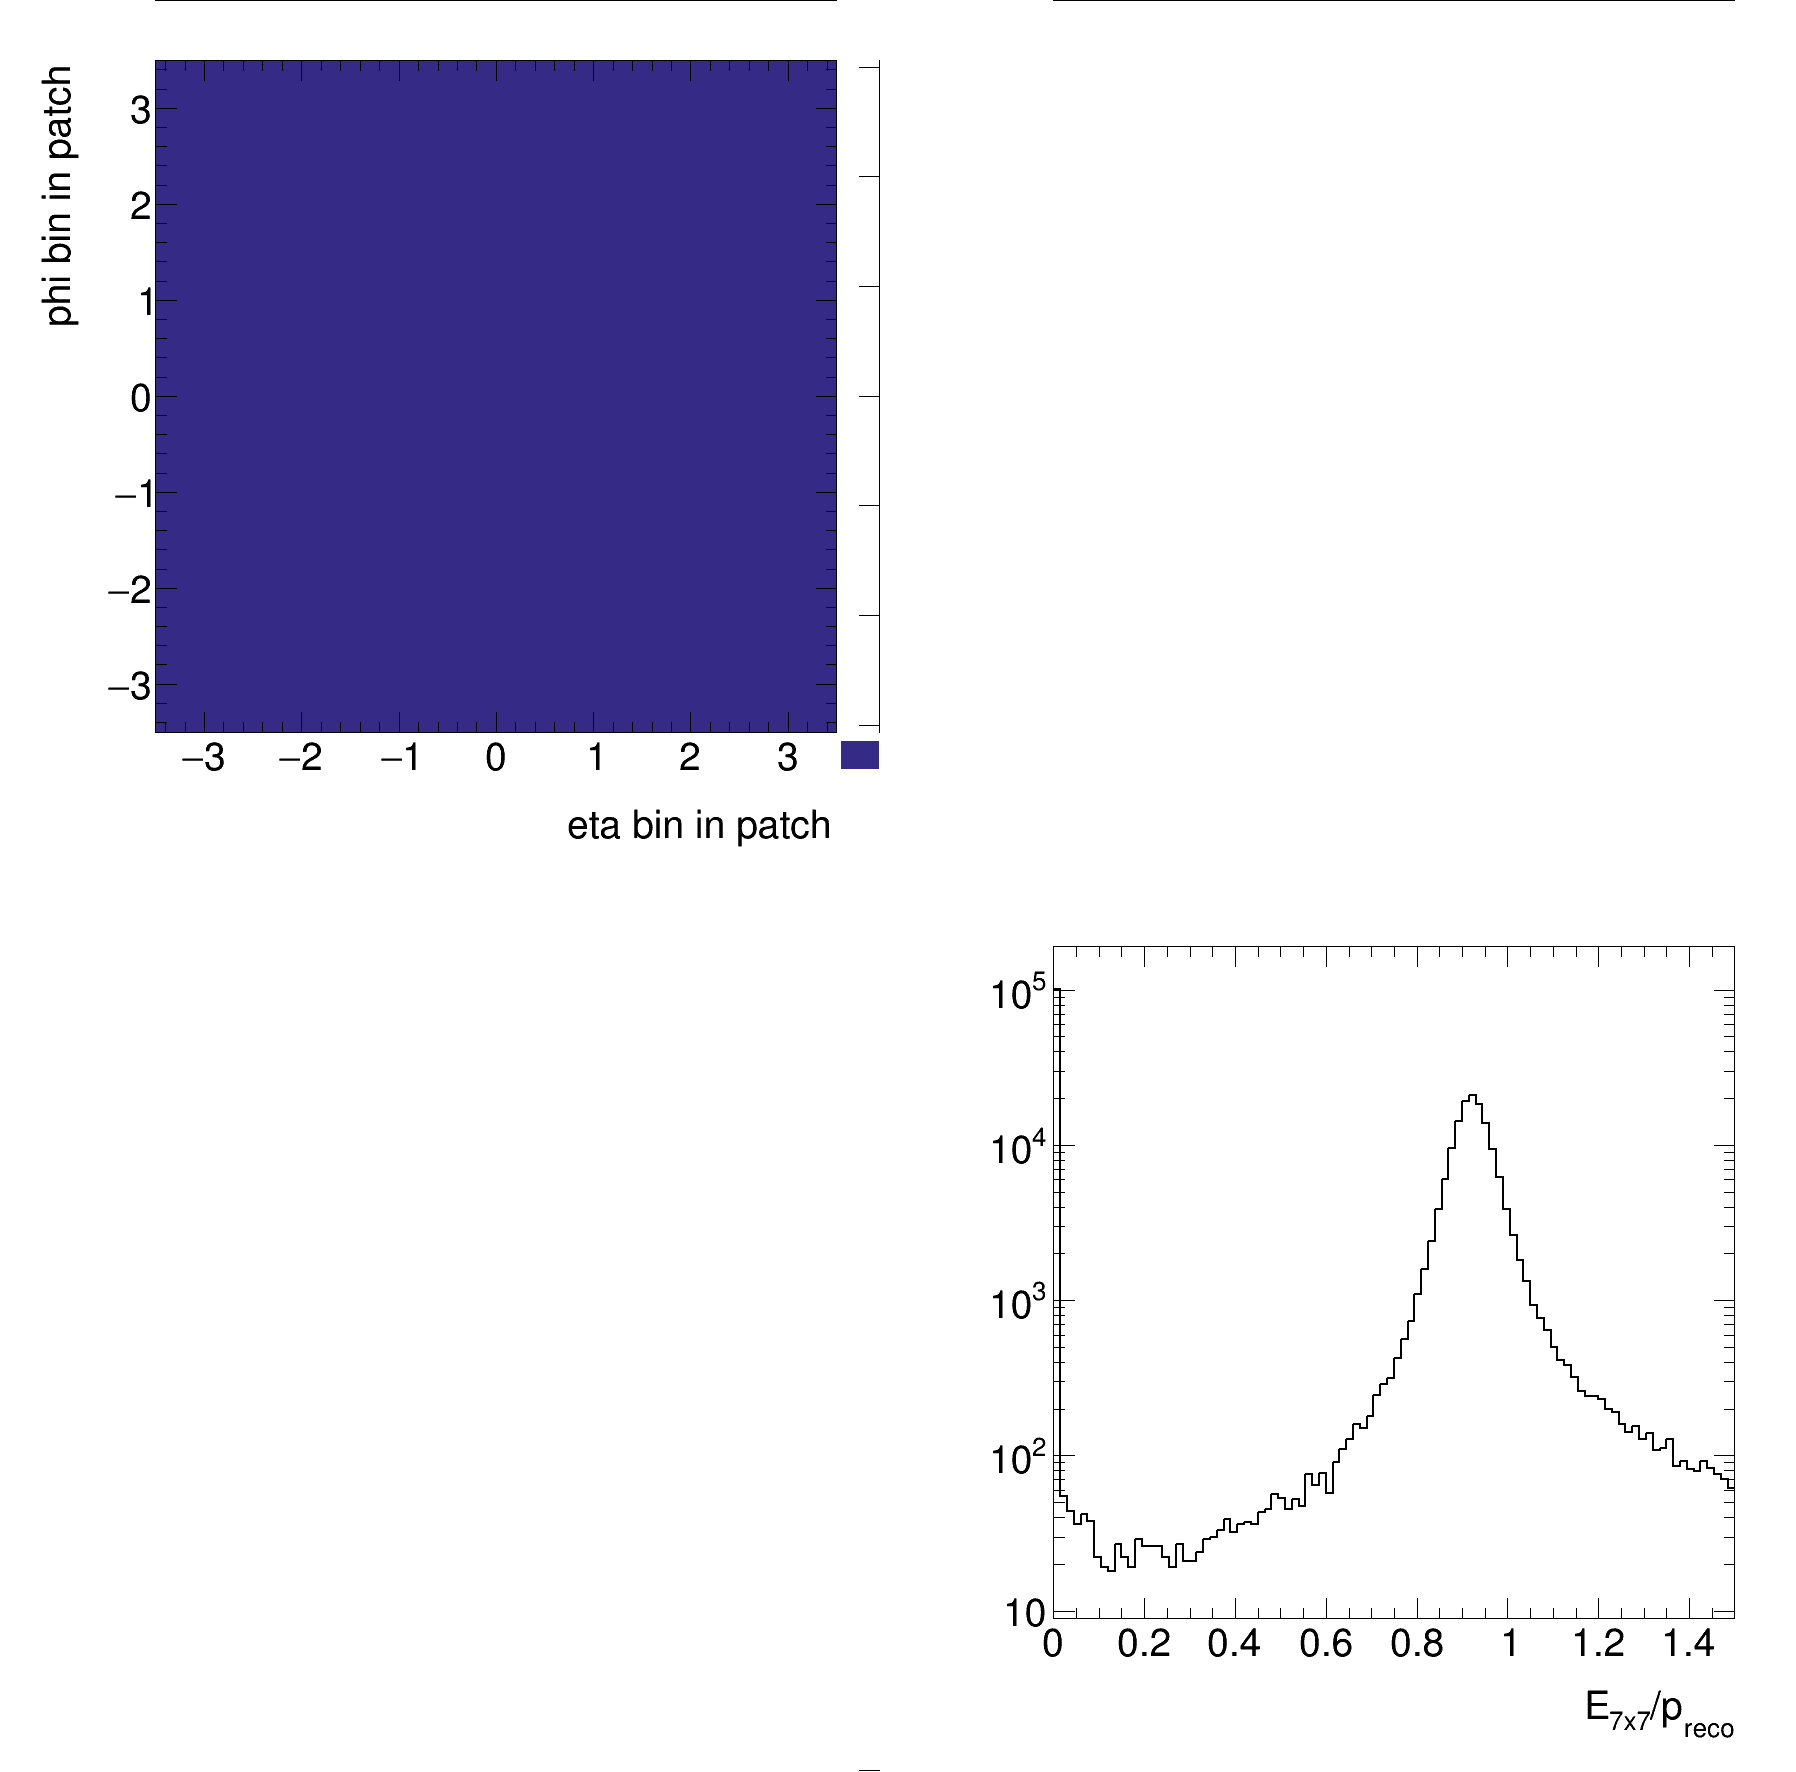

In [9]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta bin in patch;phi bin in patch",7,-3.5,3.5,7,-3.5,3.5);
        T->Draw("FEMC_Tower_iPhi_patch:FEMC_Tower_iEta_patch>>hpatch2D","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";Phi bin in patch",7,-3.5,3.5);
        T->Draw("FEMC_Tower_iPhi_patch>>hpatchPhi","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";Eta bin in patch",7,-3.5,3.5);
        T->Draw("FEMC_Tower_iEta_patch>>hpatchEta","FEMC_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",100,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

### shower shape in eta phi distance

Warning in <TS3WebFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TS3WebFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TS3WebFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TS3WebFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


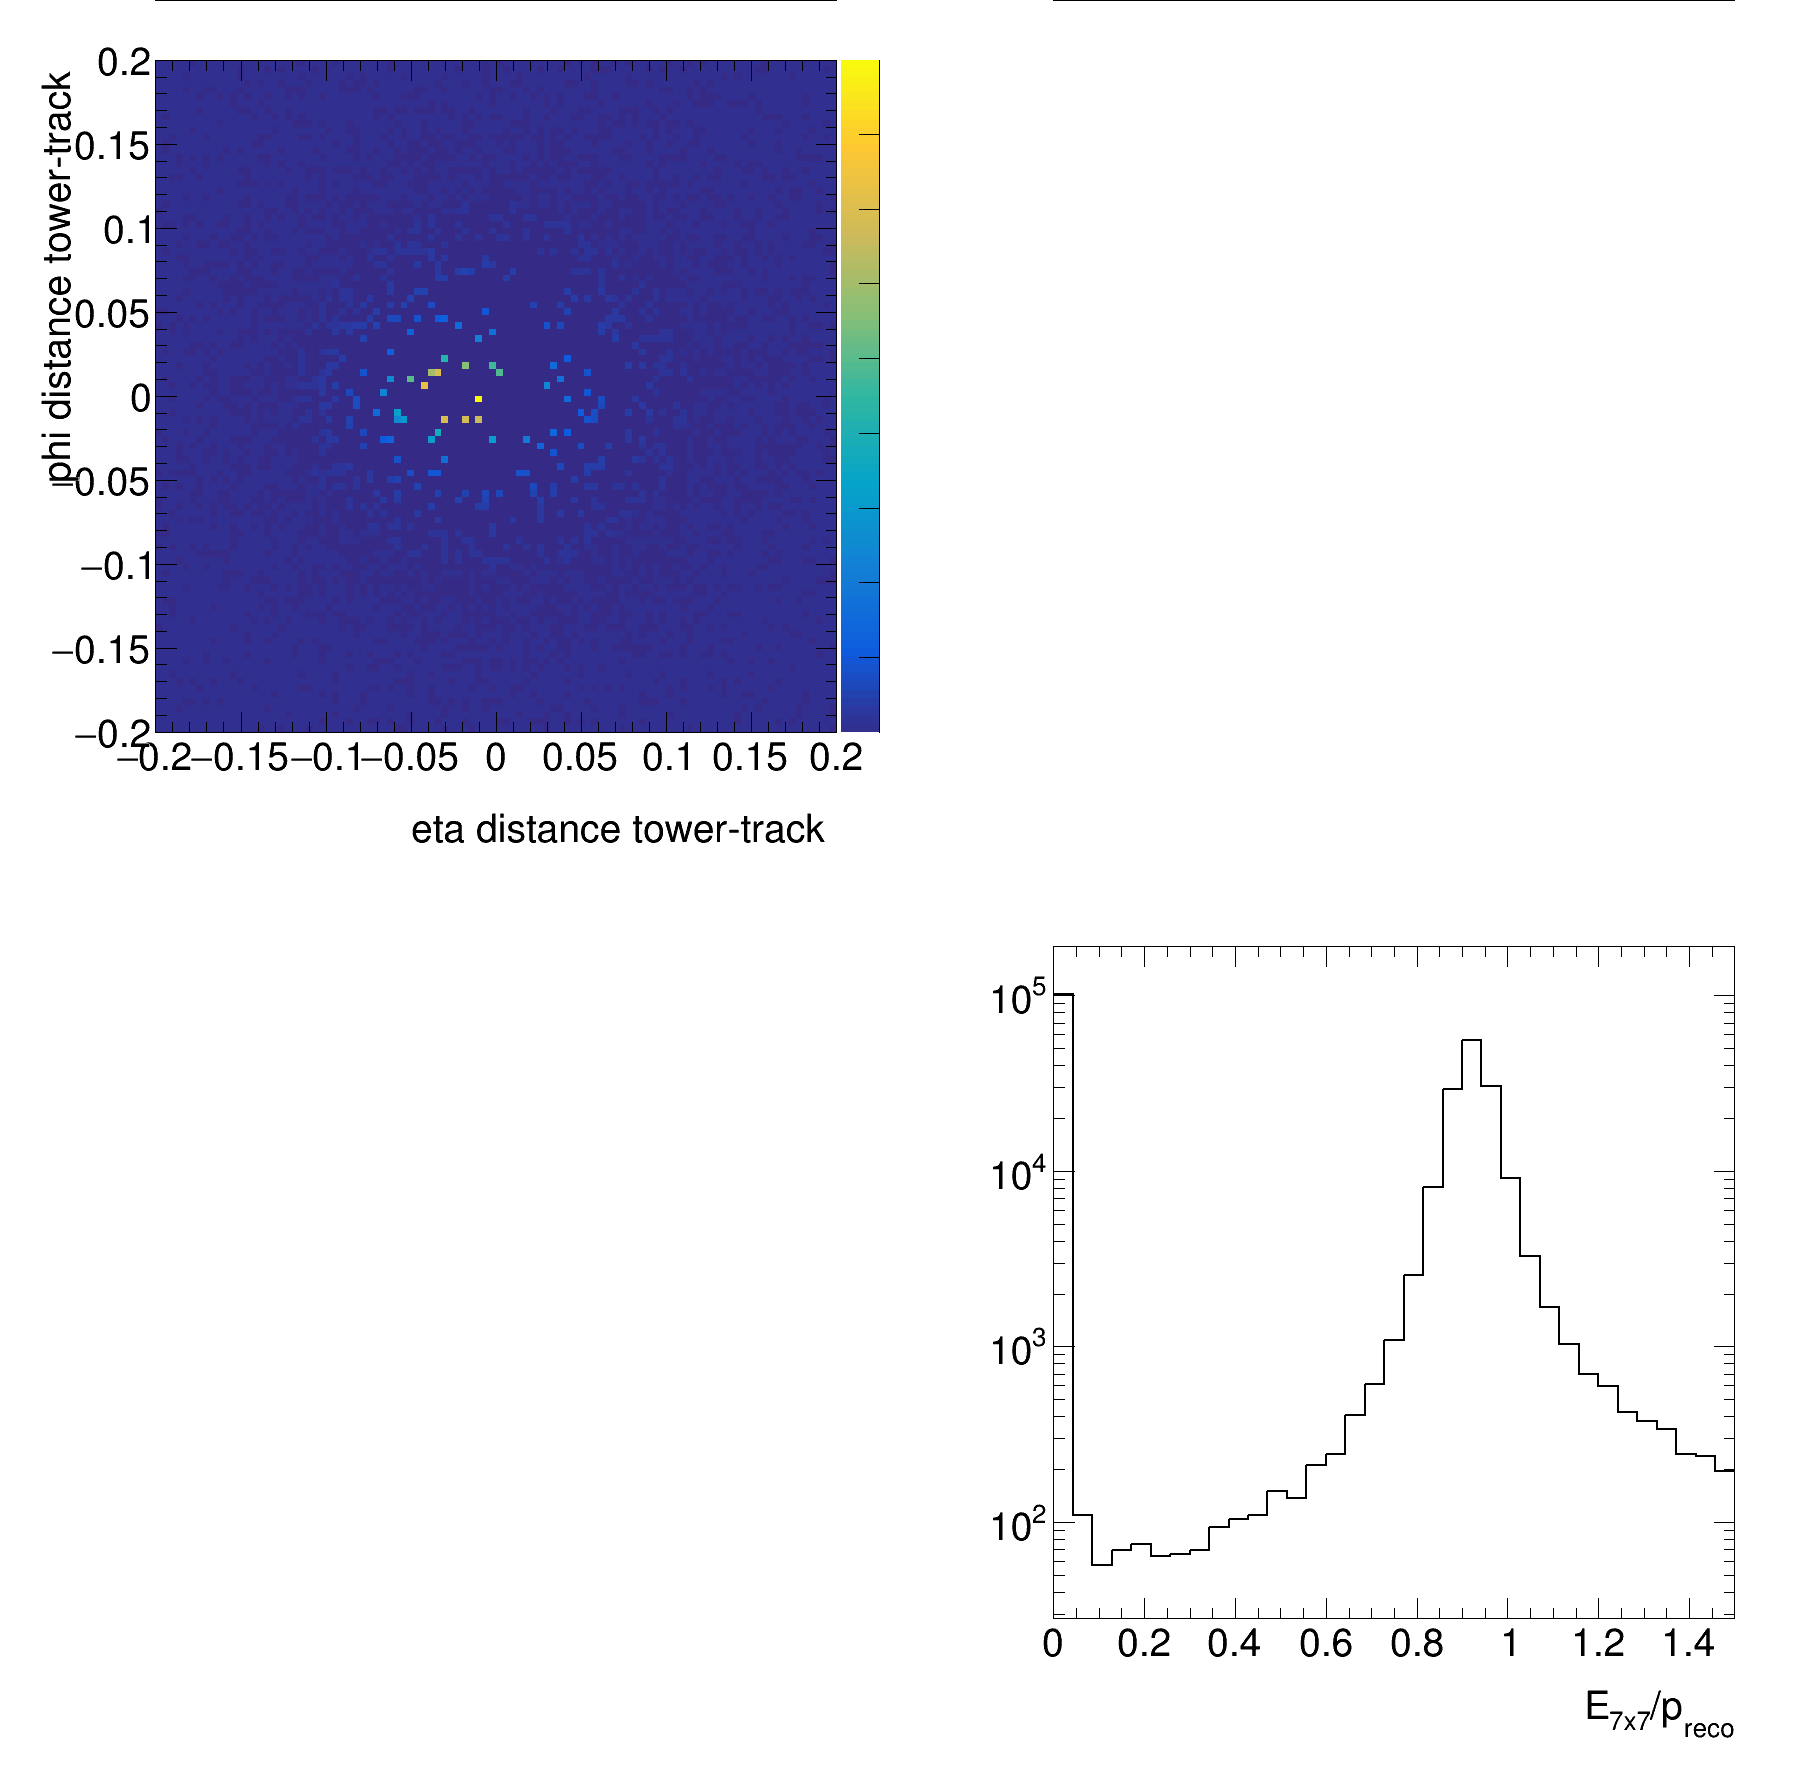

In [10]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerEtaPhiScan";
    auto c1 = new TCanvas(TString("TowerEtaPhiScan") ,
                        TString("TowerEtaPhiScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta distance tower-track;phi distance tower-track",100,-.2,.2, 100,-.2,.2);
        T->Draw("FEMC_Tower_dPhi:FEMC_Tower_dEta>>hpatch2D","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";phi distance tower-track",100,-.15,.15);
        T->Draw("FEMC_Tower_dPhi>>hpatchPhi","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";eta distance tower-track",100,-.15,.15);
        T->Draw("FEMC_Tower_dEta>>hpatchEta","FEMC_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",35,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

## Show response in eta-phi

Warning in <TS3WebFile::Append>: Replacing existing TH1: hresponse (Potential memory leak).


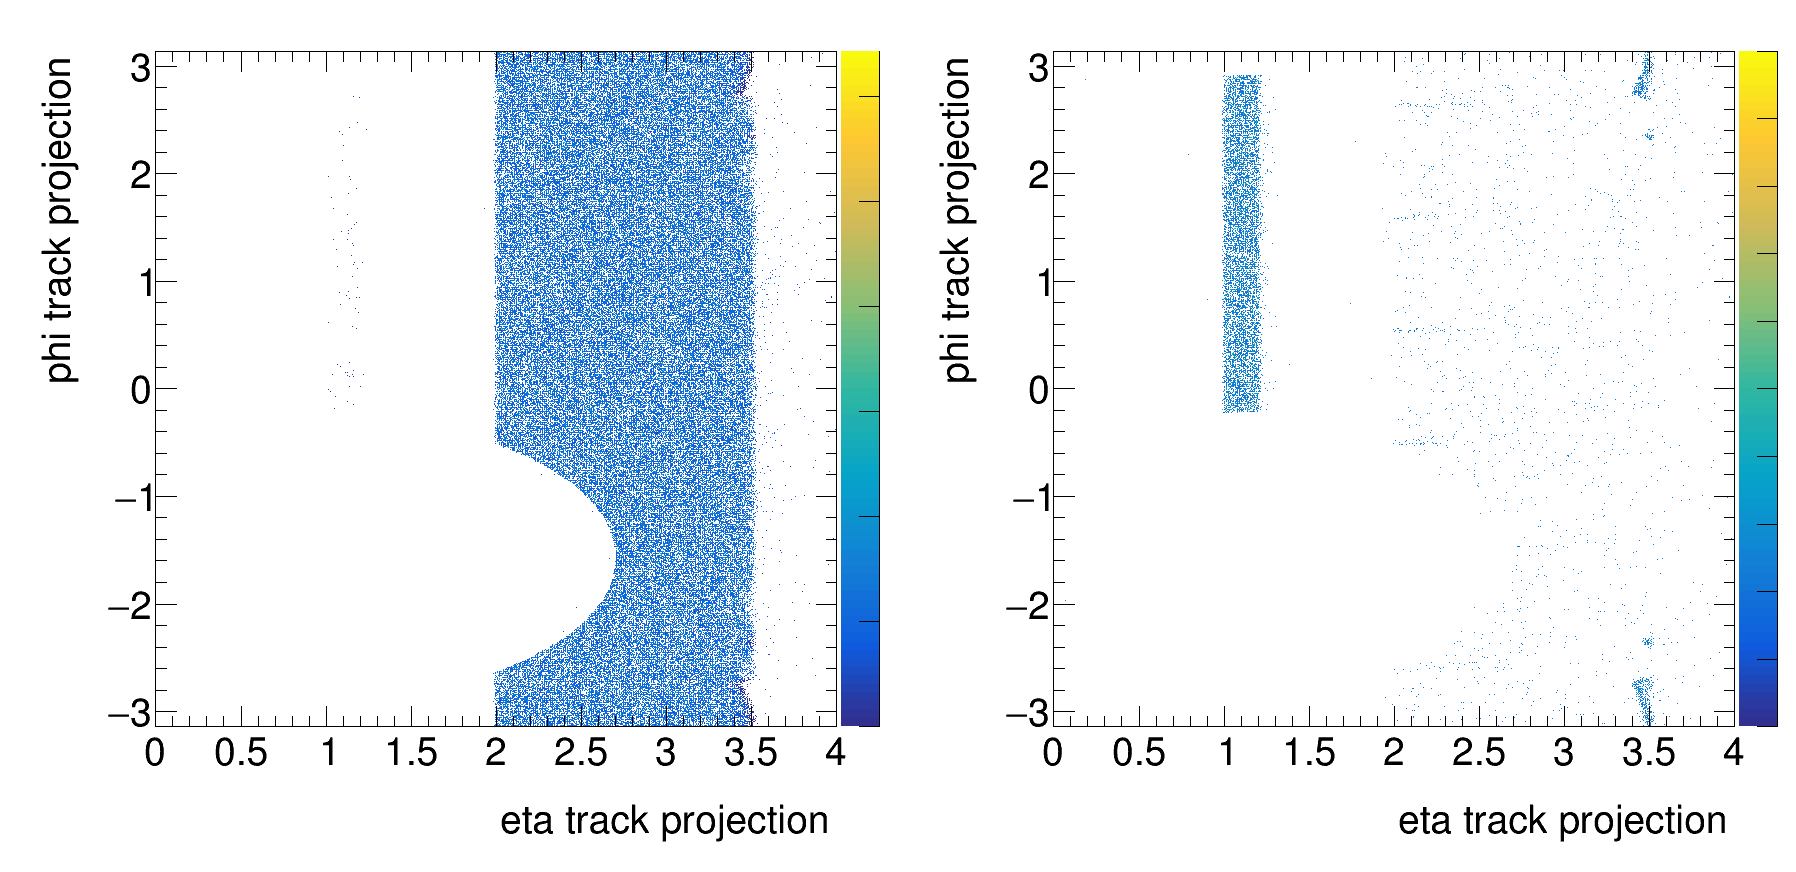

In [11]:
%%cpp

{

    
    const char *hist_name_prefix = "ShowerScan";
    auto c1 = new TCanvas(TString("ShowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(2, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hresponse",";eta track projection;phi track projection", 1000,0,4, 1000,-3.14,3.14);
        T->Draw("atan2(FEMC_proj_y,FEMC_proj_x):TMath::ATanH(FEMC_proj_z/sqrt(FEMC_proj_x**2 + FEMC_proj_y**2 + FEMC_proj_z**2))>>hresponse","FEMC_Tower_E7x7/m_truthp","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hresponse",";eta track projection;phi track projection", 1000,0,4, 1000,-3.14,3.14);
        T->Draw("atan2(FEMC_proj_y,FEMC_proj_x):TMath::ATanH(FEMC_proj_z/sqrt(FEMC_proj_x**2 + FEMC_proj_y**2 + FEMC_proj_z**2))>>hresponse","FEMC_Tower_E7x7/m_truthp<.5","colz");
        
    }
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ShowerScan


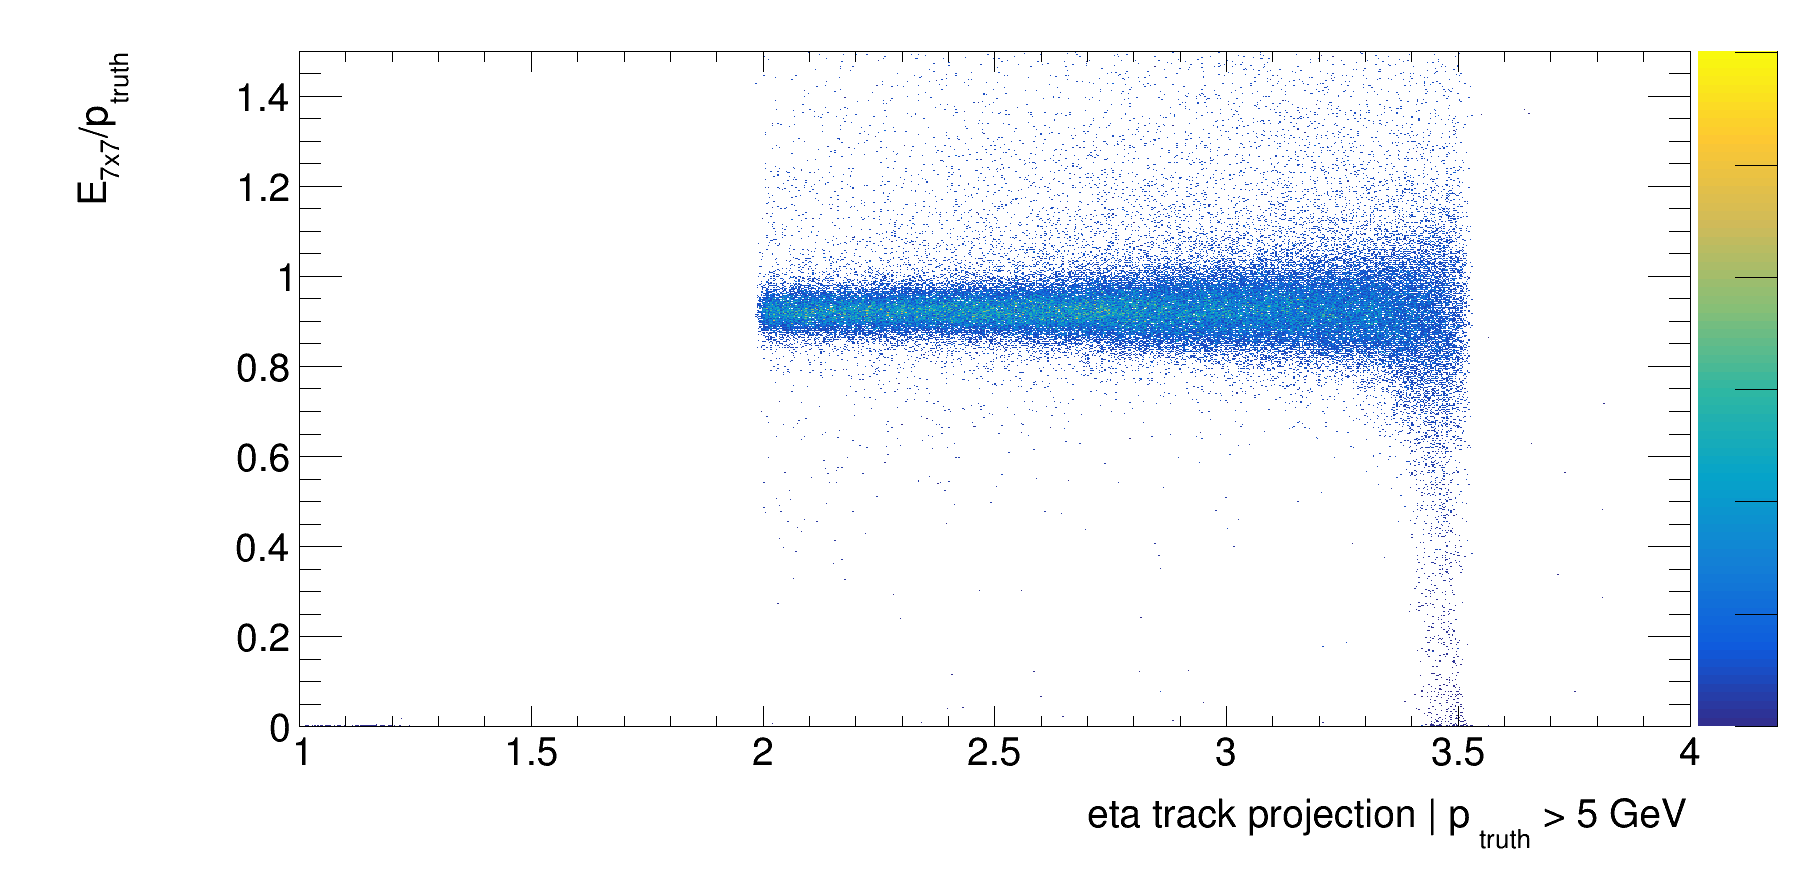

In [12]:
%%cpp

{

    
    const char *hist_name_prefix = "ShowerScan";
    auto c1 = new TCanvas(TString("ShowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hEpresponse",";eta track projection | p_{truth} > 5 GeV;E_{7x7}/p_{truth}", 1000,1,4, 1000,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p:TMath::ATanH(FEMC_proj_z/sqrt(FEMC_proj_x**2 + FEMC_proj_y**2 + FEMC_proj_z**2))>>hEpresponse","(FEMC_Tower_E7x7/m_truthp) * (m_truthp>5)","colz");
        
    }
    c1->Draw();
}

In [14]:
ROOT.hpatchPhi.Print()


TH1.Print Name  = hpatchPhi, Entries= 6939124, Total sum= -nan
